# Exploratory Data Analysis

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import json
import csv
import os
import cPickle as pickle
from collections import Counter

from sklearn.cluster import KMeans

from my_utilities import read_json_file
import matplotlib.pyplot as plt
%matplotlib inline

##Reading the data (stored as dataframes in pickled files)

In [2]:
# Loading the pickled data frames from users, businesses, and reviews.
# Assuming these data frames were obtained already using 'make_dataframes.py'
dataframe_pickle_filename = '../data/dataframes.pkl'
with open(dataframe_pickle_filename, 'r') as f:
    (user_df, business_df, review_df) = pickle.load(f)

## Find cities for businesses using k-means.

In [3]:
X = business_df[['business_latitude', 'business_longitude']].values

In [4]:
km = KMeans(10, n_jobs=8)

In [5]:
y = km.fit_predict(X)

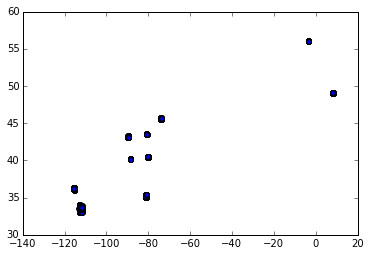

In [6]:
plt.scatter(X[:,1], X[:,0])

In [7]:
city_locations = km.cluster_centers_

In [28]:
n_businesses_per_city = Counter(y).most_common()

In [29]:
sorted_y = [c[0] for c in n_businesses_per_city]
sorted_y_map = {}                                                            
for i in range(10):                                                      
      sorted_y_map[sorted_y[i]] = i

In [30]:
business_df['business_city_int'] = map(lambda i: sorted_y_map[i], y)

In [31]:
city_names = ['Phoenix', 'Las Vegas', 'Charlotte', 'Montreal', 'Edinburgh', 'Pittsburgh',  'Madison', 'Karlsruhe',
              'Urbana-Champaign', 'Waterloo']

## Find reviews for businesses in each city

In [32]:
# Dataframe with the reviews (with business city).
review_city_df = business_df[['business_id_int', 'business_city_int']].merge(review_df, on=['business_id_int'], how='inner')

In [35]:
# Reviews for three specific cities.
review_phoenix = review_city_df[review_city_df.business_city_int == 0].drop(['business_city_int'], axis=1)   # Phoenix
review_lasvegas = review_city_df[review_city_df.business_city_int == 1].drop(['business_city_int'], axis=1)  # Las Vegas
review_montreal = review_city_df[review_city_df.business_city_int == 3].drop(['business_city_int'], axis=1)  # Montreal

In [36]:
len(review_montreal.user_id_int.unique()), len(review_phoenix.user_id_int.unique()), len(review_lasvegas.user_id_int.unique()), 

(13861, 128330, 181712)

In [37]:
len(review_montreal.business_id_int.unique()), len(review_phoenix.business_id_int.unique()), len(review_lasvegas.business_id_int.unique()), 

(3918, 25225, 16469)

In [38]:
print review_montreal.shape[0], review_phoenix.shape[0], review_lasvegas.shape[0],

49484 591192 679460


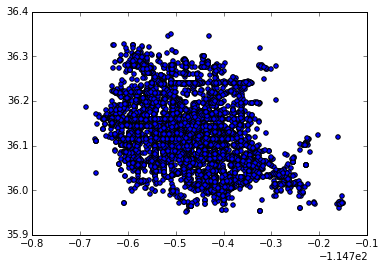

In [41]:
# Check the clustering was done correctly.
X = business_df[business_df.business_city_int==1][['business_latitude', 'business_longitude']].values
plt.scatter(X[:,1], X[:,0])

## Trying to understand the data

### Number of reviews per user.

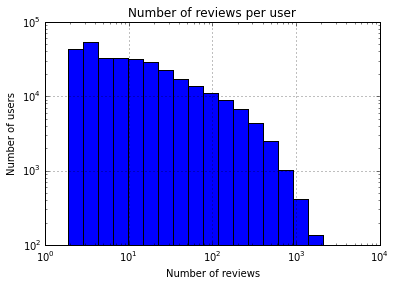

In [42]:
plt.ylim([100,100000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per user')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
user_df.user_review_count.hist(bins=np.logspace(0.1, 3.5, 20))

Users have at least 1 review.

### Number of reviews per business.

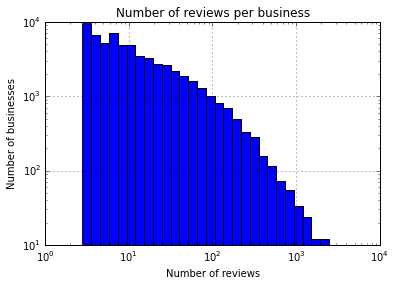

In [43]:
plt.ylim([10, 10000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Number of reviews per business')
plt.xlabel('Number of reviews')
plt.ylabel('Number of businesses')
business_df.business_review_count.hist(bins=np.logspace(0.45, 3.5, 30))

In [44]:
business_df.business_review_count.min()

3

Businesses have at least 3 reviews.

### Some counts per city

In [45]:
n_users = float(user_df.shape[0])
n_businesses = float(business_df.shape[0])
n_reviews = float(review_df.shape[0])
users_by_city = np.array(review_city_df.groupby('business_city_int').user_id_int.nunique()) / n_users
businessess_by_city = np.array(review_city_df.groupby('business_city_int').business_id_int.nunique()) / n_businesses
reviews_by_city = np.array(review_city_df.groupby('business_city_int').user_id_int.count()) / n_reviews

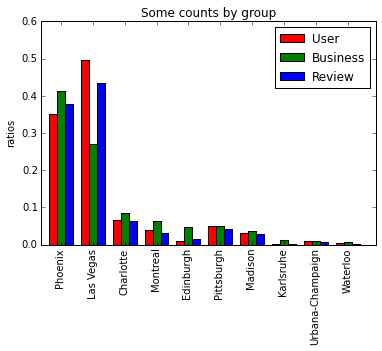

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.arange(10) # the x locations for the groups
width = 0.25        # the width of the bars

## the bars
rects0 = ax.bar(ind, users_by_city, width, color='r')
rects1 = ax.bar(ind + width, businessess_by_city, width, color='g')
rects2 = ax.bar(ind + 2 * width, reviews_by_city, width, color='b')

# axes and labels
ax.set_xlim(-width, len(ind) + width)
ax.set_ylim(0,0.6)
ax.set_ylabel('ratios')
ax.set_title('Some counts by group')
ax.set_xticks(ind + 1.5*width)
xtickNames = ax.set_xticklabels(city_names)
plt.setp(xtickNames, rotation=90, fontsize=10)

## add a legend
ax.legend((rects0[0], rects1[0], rects2[0]), ('User', 'Business', 'Review'))
plt.show()

Phoenix and Las Vegas are two biggest cities here. A unique characteristic we can see is that in Las Vegas the number of users is much greater than the number of businesses; on the other hand, in Phoenix, the number of businesses is greater than the number of users. At first, I assumed there might be many tourists in Las Vegas, but based on counts below, there are not many users who leave reviews in multiple cities (only 5%). Then two possible explanations are: (1) there are just many more users than businesses, (2) users in Las Vegas are much more active.

### Number of cities per user

Here trying to find how many cities each user left reviews.

In [47]:
cities_by_user = np.array(review_city_df.groupby('user_id_int').business_city_int.nunique())

In [48]:
sum(cities_by_user == 1) / float(n_users)

0.95011112171577383

In [49]:
sum(cities_by_user == 2) / float(n_users)

0.045563993837176006

In [50]:
sum(cities_by_user > 2) / float(n_users)

0.0043248844470501618

Most of users left reviews in only one city (95 %), and 4.56 % of users left reviews in one city. There are only 0.43 % of users who left reviews in more than two cities.

### Degree distribution

Now we can look at the network structure. The easiest stat we can look is the degree distribution.

In [51]:
degrees = np.loadtxt("../data/degrees")

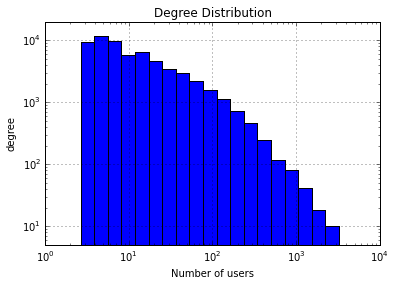

In [53]:
plt.ylim([5, 20000])
plt.gca().set_xscale("log")
plt.yscale('log')
plt.title('Degree Distribution')
plt.xlabel('Number of users')
plt.ylabel('degree')
business_df.business_review_count.hist(bins=np.logspace(0.1, 4, 25))

In [54]:
cities = [0, 1, 3]

In [56]:
cities_by_user = review_city_df.groupby('user_id_int', sort=True).business_city_int.unique()                                               
user_city_int = -np.ones(n_users)

In [61]:
n_users

366715.0

In [165]:
# Find unique users for 3 cities (Phoenix, Las Vegas, and Montreal), and store them in sets.
users_by_cities = review_city_df.groupby('business_city_int').user_id_int.unique()
users = [set(users_by_cities[0]), set(users_by_cities[1]), set(users_by_cities[3])]  
# For Phoenix (0), Las Vegas (1), and Montreal (2).

In [168]:
# Save them in a pickle file.


13861

In [162]:
users

business_city_int
0                    [8060, 199990, 3384, 155441, 261639, 218579, 3...
1                    [46340, 177645, 295863, 316201, 210745, 209694...
2                    [182439, 3620, 112912, 222341, 44377, 169122, ...
3                    [299515, 42495, 214183, 97767, 145972, 123117,...
4                    [103396, 272442, 262141, 115734, 242004, 24600...
5                    [70702, 24852, 8235, 162674, 348037, 257917, 6...
6                    [29060, 76466, 130173, 11376, 229876, 286471, ...
7                    [175202, 333679, 262967, 324697, 286096, 52424...
8                    [70990, 232678, 24772, 300859, 299430, 15954, ...
9                    [271157, 80705, 363977, 123592, 294068, 176439...
Name: user_id_int, dtype: object